# Proximal Policy Optimization


## Introduction

This code example solves the CartPole-v0 environment using a Proximal Policy Optimization (PPO) agent.


### Proximal Policy Optimization

PPO is a policy gradient method and can be used for environments with either discrete or continuous action spaces.
It trains a stochastic policy in an on-policy way. Also, it utilizes the actor critic method. The actor maps the
observation to an action and the critic gives an expectation of the rewards of the agent for the observation given.
Firstly, it collects a set of trajectories for each epoch by sampling from the latest version of the stochastic policy.
Then, the rewards-to-go and the advantage estimates are computed in order to update the policy and fit the value function.
The policy is updated via a stochastic gradient ascent optimizer, while the value function is fitted via some gradient descent algorithm.
This procedure is applied for many epochs until the environment is solved.

![Algorithm](https://i.imgur.com/rd5tda1.png)

- [PPO Original Paper](https://arxiv.org/pdf/1707.06347.pdf)
- [OpenAI Spinning Up docs - PPO](https://spinningup.openai.com/en/latest/algorithms/ppo.html)

### Note

This code example uses Keras and Tensorflow v2. It is based on the PPO Original Paper,
the OpenAI's Spinning Up docs for PPO, and the OpenAI's Spinning Up implementation of PPO using Tensorflow v1.

[OpenAI Spinning Up Github - PPO](https://github.com/openai/spinningup/blob/master/spinup/algos/tf1/ppo/ppo.py)

## Libraries

For this example the following libraries are used:

1. `numpy` for n-dimensional arrays
2. `tensorflow` and `keras` for building the deep RL PPO agent
3. `gym` for getting everything we need about the environment
4. `scipy.signal` for calculating the discounted cumulative sums of vectors

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import gym
import scipy.signal
import time
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import tqdm
%matplotlib inline
%load_ext jupyternotify

<IPython.core.display.Javascript object>

In [78]:
%run utils.ipynb
%run torque_dynamics.ipynb
sat.L_p

array([[ 0.   ,  0.251,  0.   ],
       [-0.384,  0.   ,  0.   ],
       [ 0.   ,  1.25 ,  0.   ]])

## Hyperparameters

In [3]:
# Hyperparameters of the PPO algorithm
steps_per_epoch = 500
epochs = 1000
gamma = 0.99
clip_ratio = 0.2
policy_learning_rate = 3e-4
value_function_learning_rate = 1e-3
train_policy_iterations = 80
train_value_iterations = 80
lam = 0.95
target_kl = 0.01
hidden_sizes = (400, 300)

# True if you want to render the environment
render = False

## Physics

In [4]:
def gravity_gradient_torque(quat, inertia_tensor, mean_motion):
    Ae3 = rotate_vec_with_quat(quat, np.array([0., 0., 1.]))

    return 3. * mean_motion ** 2. * cross_product(Ae3, inertia_tensor.dot(Ae3))    


def rhs(t, x, sat, action):

    quat = x[:4] / np.linalg.norm(x[:4])
    omega = x[4:7]
    h = x[7:10]
     
    omega_rel = omega - rotate_vec_with_quat(quat, np.array([0., sat.mean_motion, 0.]))    
        
    trq_gg = gravity_gradient_torque(quat, sat.J, sat.mean_motion)

    x_dot = np.zeros(16)
    omega_dot_rigid = trq_gg + action - cross_product(omega, sat.J.dot(omega) + h)
    eta_dot_flex = sat.D.dot(x[13:]) + sat.K.dot(x[10:13])

    x_dot[0] = -0.5 * quat[1:].dot(omega_rel)
    x_dot[1:4] = 0.5 * (quat[0] * omega_rel + cross_product(quat[1:], omega_rel))
    tmp = omega_dot_rigid + (sat.L_p.T).dot(eta_dot_flex)
    x_dot[4:7] = sat.Aom.dot(sat.J_inv).dot(tmp)
    x_dot[7:10] = - action
    x_dot[10:13] = x[13:]
    x_dot[13:] = - sat.Aeta.dot(eta_dot_flex + sat.L_p.dot(sat.J_inv).dot(omega_dot_rigid))
        
    return x_dot

## Initializations

In [5]:
# Initialize the environment and get the dimensionality of the
# observation space and the number of possible actions
env = TorqueDynamics(0.1, np.array([1, 0, 0, 0]), 16)
observation_dimensions = env.observation_space.shape[0]
num_actions = env.action_space.shape[0]

# Initialize the buffer
buffer = Buffer(observation_dimensions, steps_per_epoch)

# Initialize the actor and the critic as keras models
observation_input = keras.Input(shape=(observation_dimensions,), dtype=tf.float32)
logits = mlp(observation_input, list(hidden_sizes) + [num_actions], tf.nn.relu, None)
actor = keras.Model(inputs=observation_input, outputs=logits)
value = tf.squeeze(
    mlp(observation_input, list(hidden_sizes) + [1], tf.nn.relu, None), axis=1
)
critic = keras.Model(inputs=observation_input, outputs=value)

# Initialize the policy and the value function optimizers
policy_optimizer = keras.optimizers.Adam(learning_rate=policy_learning_rate)
value_optimizer = keras.optimizers.Adam(learning_rate=value_function_learning_rate)



## Train

In [65]:
%%notify
print('Accounting for the gravity')
iterations = 20
obs_shape = 16
tries = 20

for i in tqdm.tqdm(range(tries)):
  print(f'Run #{i}.')
  min_ret = train(iterations, obs_shape)
  min_ret = np.min(min_ret)
  print(f'Current batch min is {min_ret}')
  print('-'*10)
  if min_ret > 5000 and reward_thresh > 0.004:
    reward_thresh *= 0.5# - 3*(mean_ret - 1000)/40000 # linear from (1000, 0.8) to (5000, 0.5)
  

Accounting for the gravity


  0%|          | 0/20 [00:00<?, ?it/s]

Run #0.
starting training with 20 epochs
 Epoch: 1. Mean Return: 3163.871998021647. Mean Length: 500.0
 Epoch: 2. Mean Return: 2123.7806392521197. Mean Length: 500.0
 Epoch: 3. Mean Return: 2730.638224186399. Mean Length: 500.0
 Epoch: 4. Mean Return: 2830.7089064184647. Mean Length: 500.0
 Epoch: 5. Mean Return: 3165.829026170822. Mean Length: 500.0
 Epoch: 6. Mean Return: 2617.2937010858122. Mean Length: 500.0
 Epoch: 7. Mean Return: 2316.303407021235. Mean Length: 500.0
 Epoch: 8. Mean Return: 3402.1628753437762. Mean Length: 500.0
 Epoch: 9. Mean Return: 2195.6881845319917. Mean Length: 500.0
 Epoch: 10. Mean Return: 3351.0021498312576. Mean Length: 500.0
 Epoch: 11. Mean Return: 2427.6535209453923. Mean Length: 500.0
 Epoch: 12. Mean Return: 2459.45668013585. Mean Length: 500.0
 Epoch: 13. Mean Return: 3344.0207220561924. Mean Length: 500.0
 Epoch: 14. Mean Return: 2497.6373996007387. Mean Length: 500.0
 Epoch: 15. Mean Return: 3138.208049807849. Mean Length: 500.0
 Epoch: 16. Mea

  5%|▌         | 1/20 [01:29<28:14, 89.17s/it]

 Epoch: 20. Mean Return: 2650.1130225625407. Mean Length: 500.0
Current batch mean is 2123.7806392521197
----------
Run #1.
starting training with 20 epochs
 Epoch: 1. Mean Return: 2912.4505703263694. Mean Length: 500.0
 Epoch: 2. Mean Return: 2669.9464759469424. Mean Length: 500.0
 Epoch: 3. Mean Return: 3228.280291956966. Mean Length: 500.0
 Epoch: 4. Mean Return: 2874.0430447372287. Mean Length: 500.0
 Epoch: 5. Mean Return: 2175.9403973096037. Mean Length: 500.0
 Epoch: 6. Mean Return: 2281.8887427972886. Mean Length: 500.0
 Epoch: 7. Mean Return: 2324.420837982473. Mean Length: 500.0
 Epoch: 8. Mean Return: 2888.6953621113194. Mean Length: 500.0
 Epoch: 9. Mean Return: 2446.871750205518. Mean Length: 500.0
 Epoch: 10. Mean Return: 2677.8698616866222. Mean Length: 500.0
 Epoch: 11. Mean Return: 2716.155945836074. Mean Length: 500.0
 Epoch: 12. Mean Return: 2922.7486688633976. Mean Length: 500.0
 Epoch: 13. Mean Return: 2613.2618176333876. Mean Length: 500.0
 Epoch: 14. Mean Return:

 10%|█         | 2/20 [03:00<27:12, 90.70s/it]

 Epoch: 20. Mean Return: 3288.2500401597604. Mean Length: 500.0
Current batch mean is 2170.7131331635815
----------
Run #2.
starting training with 20 epochs
 Epoch: 1. Mean Return: 3226.277813692138. Mean Length: 500.0
 Epoch: 2. Mean Return: 2665.69551678735. Mean Length: 500.0
 Epoch: 3. Mean Return: 3013.6354626743255. Mean Length: 500.0
 Epoch: 4. Mean Return: 2692.953017902338. Mean Length: 500.0
 Epoch: 5. Mean Return: 2971.330108913985. Mean Length: 500.0
 Epoch: 6. Mean Return: 3047.3920172338017. Mean Length: 500.0
 Epoch: 7. Mean Return: 3409.6493586150204. Mean Length: 500.0
 Epoch: 8. Mean Return: 2255.238310938542. Mean Length: 500.0
 Epoch: 9. Mean Return: 2943.6044795200287. Mean Length: 500.0
 Epoch: 10. Mean Return: 2888.60246126877. Mean Length: 500.0
 Epoch: 11. Mean Return: 2296.7523478676317. Mean Length: 500.0
 Epoch: 12. Mean Return: 2551.4770875702548. Mean Length: 500.0
 Epoch: 13. Mean Return: 2230.780737205773. Mean Length: 500.0
 Epoch: 14. Mean Return: 3076

 15%|█▌        | 3/20 [04:35<26:08, 92.28s/it]

 Epoch: 20. Mean Return: 2268.9770798930404. Mean Length: 500.0
Current batch mean is 2230.780737205773
----------
Run #3.
starting training with 20 epochs
 Epoch: 1. Mean Return: 3256.8988519186705. Mean Length: 500.0
 Epoch: 2. Mean Return: 3086.0200733989363. Mean Length: 500.0
 Epoch: 3. Mean Return: 2942.7477969580455. Mean Length: 500.0
 Epoch: 4. Mean Return: 2972.90964907125. Mean Length: 500.0
 Epoch: 5. Mean Return: 3250.9702281732075. Mean Length: 500.0
 Epoch: 6. Mean Return: 3286.858435783473. Mean Length: 500.0
 Epoch: 7. Mean Return: 3135.4552585208426. Mean Length: 500.0
 Epoch: 8. Mean Return: 3332.9003894999237. Mean Length: 500.0
 Epoch: 9. Mean Return: 2220.169882929496. Mean Length: 500.0
 Epoch: 10. Mean Return: 3360.445275261667. Mean Length: 500.0
 Epoch: 11. Mean Return: 3330.2722592858013. Mean Length: 500.0
 Epoch: 12. Mean Return: 2284.265804657128. Mean Length: 500.0
 Epoch: 13. Mean Return: 3046.631029454909. Mean Length: 500.0
 Epoch: 14. Mean Return: 260

 20%|██        | 4/20 [06:04<24:21, 91.32s/it]

 Epoch: 20. Mean Return: 2645.789951915739. Mean Length: 500.0
Current batch mean is 2220.169882929496
----------
Run #4.
starting training with 20 epochs
 Epoch: 1. Mean Return: 2423.8213382948475. Mean Length: 500.0
 Epoch: 2. Mean Return: 3235.6410533105263. Mean Length: 500.0
 Epoch: 3. Mean Return: 2293.9363959198317. Mean Length: 500.0
 Epoch: 4. Mean Return: 2464.3055254400692. Mean Length: 500.0
 Epoch: 5. Mean Return: 3193.4672529844797. Mean Length: 500.0
 Epoch: 6. Mean Return: 2696.856354935507. Mean Length: 500.0
 Epoch: 7. Mean Return: 2898.1403632007805. Mean Length: 500.0
 Epoch: 8. Mean Return: 2246.3751909063144. Mean Length: 500.0
 Epoch: 9. Mean Return: 3026.777729302719. Mean Length: 500.0
 Epoch: 10. Mean Return: 2664.9613222271237. Mean Length: 500.0
 Epoch: 11. Mean Return: 3215.237071938373. Mean Length: 500.0
 Epoch: 12. Mean Return: 2821.1830675658043. Mean Length: 500.0
 Epoch: 13. Mean Return: 2721.7822672511143. Mean Length: 500.0
 Epoch: 14. Mean Return: 

 25%|██▌       | 5/20 [07:33<22:36, 90.46s/it]

 Epoch: 20. Mean Return: 2723.2254951823593. Mean Length: 500.0
Current batch mean is 2217.8500314113717
----------
Run #5.
starting training with 20 epochs
 Epoch: 1. Mean Return: 2701.2272578308243. Mean Length: 500.0
 Epoch: 2. Mean Return: 3486.1257987587524. Mean Length: 500.0
 Epoch: 3. Mean Return: 2765.670450145149. Mean Length: 500.0
 Epoch: 4. Mean Return: 2426.121691997233. Mean Length: 500.0
 Epoch: 5. Mean Return: 2935.346820023824. Mean Length: 500.0
 Epoch: 6. Mean Return: 2710.603569616918. Mean Length: 500.0
 Epoch: 7. Mean Return: 3465.39720834769. Mean Length: 500.0
 Epoch: 8. Mean Return: 2936.731163628752. Mean Length: 500.0
 Epoch: 9. Mean Return: 2472.0950617849744. Mean Length: 500.0
 Epoch: 10. Mean Return: 2593.2092711688642. Mean Length: 500.0
 Epoch: 11. Mean Return: 2642.147458971457. Mean Length: 500.0
 Epoch: 12. Mean Return: 2427.5066173927653. Mean Length: 500.0
 Epoch: 13. Mean Return: 3330.5969821125054. Mean Length: 500.0
 Epoch: 14. Mean Return: 292

 30%|███       | 6/20 [09:03<21:01, 90.11s/it]

 Epoch: 20. Mean Return: 2342.231675579944. Mean Length: 500.0
Current batch mean is 2342.231675579944
----------
Run #6.
starting training with 20 epochs
 Epoch: 1. Mean Return: 3485.462680485551. Mean Length: 500.0
 Epoch: 2. Mean Return: 2914.3674582565936. Mean Length: 500.0
 Epoch: 3. Mean Return: 2707.432205239017. Mean Length: 500.0
 Epoch: 4. Mean Return: 2528.526242079737. Mean Length: 500.0
 Epoch: 5. Mean Return: 3201.7631634057716. Mean Length: 500.0
 Epoch: 6. Mean Return: 2520.123790455836. Mean Length: 500.0
 Epoch: 7. Mean Return: 2135.7014566437706. Mean Length: 500.0
 Epoch: 8. Mean Return: 2259.5702278523736. Mean Length: 500.0
 Epoch: 9. Mean Return: 2525.7190519068163. Mean Length: 500.0
 Epoch: 10. Mean Return: 2259.5329030922107. Mean Length: 500.0
 Epoch: 11. Mean Return: 2555.0963127119426. Mean Length: 500.0
 Epoch: 12. Mean Return: 2654.5138508810924. Mean Length: 500.0
 Epoch: 13. Mean Return: 3086.135370577128. Mean Length: 500.0
 Epoch: 14. Mean Return: 27

 35%|███▌      | 7/20 [10:35<19:41, 90.89s/it]

 Epoch: 20. Mean Return: 2157.5496085256727. Mean Length: 500.0
Current batch mean is 2135.7014566437706
----------
Run #7.
starting training with 20 epochs
 Epoch: 1. Mean Return: 3283.654956514655. Mean Length: 500.0
 Epoch: 2. Mean Return: 3046.98670883758. Mean Length: 500.0
 Epoch: 3. Mean Return: 2557.6498403426103. Mean Length: 500.0
 Epoch: 4. Mean Return: 2309.280932312554. Mean Length: 500.0
 Epoch: 5. Mean Return: 2355.9385833814167. Mean Length: 500.0
 Epoch: 6. Mean Return: 2702.363010853454. Mean Length: 500.0
 Epoch: 7. Mean Return: 2306.3255087176617. Mean Length: 500.0
 Epoch: 8. Mean Return: 2711.559979199556. Mean Length: 500.0
 Epoch: 9. Mean Return: 3209.9509552437244. Mean Length: 500.0
 Epoch: 10. Mean Return: 3117.4907314817374. Mean Length: 500.0
 Epoch: 11. Mean Return: 2735.950177004876. Mean Length: 500.0
 Epoch: 12. Mean Return: 3587.9124636908655. Mean Length: 500.0
 Epoch: 13. Mean Return: 2690.742481802989. Mean Length: 500.0
 Epoch: 14. Mean Return: 321

 40%|████      | 8/20 [12:04<18:03, 90.26s/it]

 Epoch: 20. Mean Return: 3234.392162892392. Mean Length: 500.0
Current batch mean is 2306.3255087176617
----------
Run #8.
starting training with 20 epochs
 Epoch: 1. Mean Return: 2916.903807041918. Mean Length: 500.0
 Epoch: 2. Mean Return: 2623.2488604553273. Mean Length: 500.0
 Epoch: 3. Mean Return: 2781.5345560741375. Mean Length: 500.0
 Epoch: 4. Mean Return: 2506.8448030454906. Mean Length: 500.0
 Epoch: 5. Mean Return: 2568.2537917162686. Mean Length: 500.0
 Epoch: 6. Mean Return: 2681.350571467321. Mean Length: 500.0
 Epoch: 7. Mean Return: 2430.146325643672. Mean Length: 500.0
 Epoch: 8. Mean Return: 3162.05215330605. Mean Length: 500.0
 Epoch: 9. Mean Return: 3014.1964232936793. Mean Length: 500.0
 Epoch: 10. Mean Return: 2092.7487821714035. Mean Length: 500.0
 Epoch: 11. Mean Return: 2449.9652376835693. Mean Length: 500.0
 Epoch: 12. Mean Return: 3095.4719035595967. Mean Length: 500.0
 Epoch: 13. Mean Return: 2994.3459896185655. Mean Length: 500.0
 Epoch: 14. Mean Return: 2

 45%|████▌     | 9/20 [13:34<16:31, 90.14s/it]

 Epoch: 20. Mean Return: 2393.2416322717727. Mean Length: 500.0
Current batch mean is 2092.7487821714035
----------
Run #9.
starting training with 20 epochs
 Epoch: 1. Mean Return: 2456.5304679130586. Mean Length: 500.0
 Epoch: 2. Mean Return: 2830.024625378463. Mean Length: 500.0
 Epoch: 3. Mean Return: 3456.0195553356275. Mean Length: 500.0
 Epoch: 4. Mean Return: 2852.479706444602. Mean Length: 500.0
 Epoch: 5. Mean Return: 3403.0012775176724. Mean Length: 500.0
 Epoch: 6. Mean Return: 3561.6165069603385. Mean Length: 500.0
 Epoch: 7. Mean Return: 2781.759392104987. Mean Length: 500.0
 Epoch: 8. Mean Return: 2306.371886141183. Mean Length: 500.0
 Epoch: 9. Mean Return: 3223.2953882967945. Mean Length: 500.0
 Epoch: 10. Mean Return: 3012.3759219498274. Mean Length: 500.0
 Epoch: 11. Mean Return: 3364.3676223887846. Mean Length: 500.0
 Epoch: 12. Mean Return: 3057.300240104385. Mean Length: 500.0
 Epoch: 13. Mean Return: 3156.4841070699295. Mean Length: 500.0
 Epoch: 14. Mean Return: 

 50%|█████     | 10/20 [15:03<14:59, 89.91s/it]

 Epoch: 20. Mean Return: 2567.103950176929. Mean Length: 500.0
Current batch mean is 2306.371886141183
----------
Run #10.
starting training with 20 epochs
 Epoch: 1. Mean Return: 3216.775610691162. Mean Length: 500.0
 Epoch: 2. Mean Return: 3057.327882318976. Mean Length: 500.0
 Epoch: 3. Mean Return: 3295.848072438155. Mean Length: 500.0
 Epoch: 4. Mean Return: 3471.764853398225. Mean Length: 500.0
 Epoch: 5. Mean Return: 2483.459406995497. Mean Length: 500.0
 Epoch: 6. Mean Return: 2762.6844167330755. Mean Length: 500.0
 Epoch: 7. Mean Return: 2985.6305469242684. Mean Length: 500.0
 Epoch: 8. Mean Return: 2890.8876344832943. Mean Length: 500.0
 Epoch: 9. Mean Return: 3242.357623880593. Mean Length: 500.0
 Epoch: 10. Mean Return: 3417.801010510278. Mean Length: 500.0
 Epoch: 11. Mean Return: 3313.7577708019767. Mean Length: 500.0
 Epoch: 12. Mean Return: 2891.5355856052042. Mean Length: 500.0
 Epoch: 13. Mean Return: 3423.457139720452. Mean Length: 500.0
 Epoch: 14. Mean Return: 2207

 55%|█████▌    | 11/20 [16:34<13:30, 90.01s/it]

 Epoch: 20. Mean Return: 3249.048090929702. Mean Length: 500.0
Current batch mean is 2207.4428055872413
----------
Run #11.
starting training with 20 epochs
 Epoch: 1. Mean Return: 2658.10546536962. Mean Length: 500.0
 Epoch: 2. Mean Return: 2479.977751085926. Mean Length: 500.0
 Epoch: 3. Mean Return: 2142.3746930804414. Mean Length: 500.0
 Epoch: 4. Mean Return: 3135.789892396177. Mean Length: 500.0
 Epoch: 5. Mean Return: 2031.4279180194078. Mean Length: 500.0
 Epoch: 6. Mean Return: 2020.9221849549929. Mean Length: 500.0
 Epoch: 7. Mean Return: 3331.2409692518136. Mean Length: 500.0
 Epoch: 8. Mean Return: 2338.3947882193593. Mean Length: 500.0
 Epoch: 9. Mean Return: 2632.3889186862084. Mean Length: 500.0
 Epoch: 10. Mean Return: 2566.749017395636. Mean Length: 500.0
 Epoch: 11. Mean Return: 1959.7826806725975. Mean Length: 500.0
 Epoch: 12. Mean Return: 2383.165077768395. Mean Length: 500.0
 Epoch: 13. Mean Return: 2844.1756544816803. Mean Length: 500.0
 Epoch: 14. Mean Return: 2

 60%|██████    | 12/20 [18:02<11:56, 89.53s/it]

 Epoch: 20. Mean Return: 3063.982845307764. Mean Length: 500.0
Current batch mean is 1959.7826806725975
----------
Run #12.
starting training with 20 epochs
 Epoch: 1. Mean Return: 2028.0296990865095. Mean Length: 500.0
 Epoch: 2. Mean Return: 3104.5756989637152. Mean Length: 500.0
 Epoch: 3. Mean Return: 2904.191420838054. Mean Length: 500.0
 Epoch: 4. Mean Return: 2894.637977237004. Mean Length: 500.0
 Epoch: 5. Mean Return: 2909.693762389006. Mean Length: 500.0
 Epoch: 6. Mean Return: 3260.404533355095. Mean Length: 500.0
 Epoch: 7. Mean Return: 3251.5183452782326. Mean Length: 500.0
 Epoch: 8. Mean Return: 2562.0341448581303. Mean Length: 500.0
 Epoch: 9. Mean Return: 2177.73874525296. Mean Length: 500.0
 Epoch: 10. Mean Return: 3378.670419733651. Mean Length: 500.0
 Epoch: 11. Mean Return: 2948.2975404567715. Mean Length: 500.0
 Epoch: 12. Mean Return: 2030.772808562281. Mean Length: 500.0
 Epoch: 13. Mean Return: 3392.1858163838165. Mean Length: 500.0
 Epoch: 14. Mean Return: 235

 65%|██████▌   | 13/20 [19:37<10:37, 91.03s/it]

 Epoch: 20. Mean Return: 3140.073601239101. Mean Length: 500.0
Current batch mean is 2028.0296990865095
----------
Run #13.
starting training with 20 epochs
 Epoch: 1. Mean Return: 2711.936428028649. Mean Length: 500.0
 Epoch: 2. Mean Return: 2704.4936420896133. Mean Length: 500.0
 Epoch: 3. Mean Return: 2870.436719559673. Mean Length: 500.0
 Epoch: 4. Mean Return: 2901.139006255186. Mean Length: 500.0
 Epoch: 5. Mean Return: 2479.029904387929. Mean Length: 500.0
 Epoch: 6. Mean Return: 3013.995732700716. Mean Length: 500.0
 Epoch: 7. Mean Return: 2319.0843350069126. Mean Length: 500.0
 Epoch: 8. Mean Return: 2500.9947619543877. Mean Length: 500.0
 Epoch: 9. Mean Return: 3128.2815346729476. Mean Length: 500.0
 Epoch: 10. Mean Return: 2596.6141334194235. Mean Length: 500.0
 Epoch: 11. Mean Return: 3394.033516911431. Mean Length: 500.0
 Epoch: 12. Mean Return: 2575.485259554407. Mean Length: 500.0
 Epoch: 13. Mean Return: 2671.472689910488. Mean Length: 500.0
 Epoch: 14. Mean Return: 233

 70%|███████   | 14/20 [21:08<09:06, 91.05s/it]

 Epoch: 20. Mean Return: 2663.907897009001. Mean Length: 500.0
Current batch mean is 2319.0843350069126
----------
Run #14.
starting training with 20 epochs
 Epoch: 1. Mean Return: 2750.341422260016. Mean Length: 500.0
 Epoch: 2. Mean Return: 2547.3796964091075. Mean Length: 500.0
 Epoch: 3. Mean Return: 3557.0999987296395. Mean Length: 500.0
 Epoch: 4. Mean Return: 3309.981096477354. Mean Length: 500.0
 Epoch: 5. Mean Return: 3317.7973642926904. Mean Length: 500.0
 Epoch: 6. Mean Return: 2145.608896420664. Mean Length: 500.0
 Epoch: 7. Mean Return: 2768.705571625694. Mean Length: 500.0
 Epoch: 8. Mean Return: 2285.5020741506182. Mean Length: 500.0
 Epoch: 9. Mean Return: 2659.3463756909223. Mean Length: 500.0
 Epoch: 10. Mean Return: 3564.0557827326934. Mean Length: 500.0
 Epoch: 11. Mean Return: 2874.012733825991. Mean Length: 500.0
 Epoch: 12. Mean Return: 2186.4867923337847. Mean Length: 500.0
 Epoch: 13. Mean Return: 2872.2843517136066. Mean Length: 500.0
 Epoch: 14. Mean Return: 

 75%|███████▌  | 15/20 [22:37<07:32, 90.42s/it]

 Epoch: 20. Mean Return: 2349.9496329709104. Mean Length: 500.0
Current batch mean is 2145.608896420664
----------
Run #15.
starting training with 20 epochs
 Epoch: 1. Mean Return: 2771.835437358469. Mean Length: 500.0
 Epoch: 2. Mean Return: 2992.3788827057347. Mean Length: 500.0
 Epoch: 3. Mean Return: 3145.365355184794. Mean Length: 500.0
 Epoch: 4. Mean Return: 3411.0605788213115. Mean Length: 500.0
 Epoch: 5. Mean Return: 3005.601762552115. Mean Length: 500.0
 Epoch: 6. Mean Return: 3465.7068972955813. Mean Length: 500.0
 Epoch: 7. Mean Return: 3132.544247807525. Mean Length: 500.0
 Epoch: 8. Mean Return: 2332.7538101254017. Mean Length: 500.0
 Epoch: 9. Mean Return: 3360.423192455785. Mean Length: 500.0
 Epoch: 10. Mean Return: 2754.641231608121. Mean Length: 500.0
 Epoch: 11. Mean Return: 2701.9051516092313. Mean Length: 500.0
 Epoch: 12. Mean Return: 2495.842293318925. Mean Length: 500.0
 Epoch: 13. Mean Return: 2914.008888311683. Mean Length: 500.0
 Epoch: 14. Mean Return: 322

 80%|████████  | 16/20 [24:12<06:07, 91.81s/it]

 Epoch: 20. Mean Return: 2380.115462296652. Mean Length: 500.0
Current batch mean is 2332.7538101254017
----------
Run #16.
starting training with 20 epochs
 Epoch: 1. Mean Return: 2457.8060065948534. Mean Length: 500.0
 Epoch: 2. Mean Return: 2752.2260242192606. Mean Length: 500.0
 Epoch: 3. Mean Return: 3331.087150280787. Mean Length: 500.0
 Epoch: 4. Mean Return: 2537.076291822343. Mean Length: 500.0
 Epoch: 5. Mean Return: 2311.685502639446. Mean Length: 500.0
 Epoch: 6. Mean Return: 2524.6823372382546. Mean Length: 500.0
 Epoch: 7. Mean Return: 2679.1688662517267. Mean Length: 500.0
 Epoch: 8. Mean Return: 3424.0068617607762. Mean Length: 500.0
 Epoch: 9. Mean Return: 2335.453420324712. Mean Length: 500.0
 Epoch: 10. Mean Return: 2794.2276811840356. Mean Length: 500.0
 Epoch: 11. Mean Return: 2800.376305301498. Mean Length: 500.0
 Epoch: 12. Mean Return: 2454.221214428085. Mean Length: 500.0
 Epoch: 13. Mean Return: 2654.605743464248. Mean Length: 500.0
 Epoch: 14. Mean Return: 25

 85%|████████▌ | 17/20 [25:47<04:38, 92.90s/it]

 Epoch: 20. Mean Return: 2772.8714183561706. Mean Length: 500.0
Current batch mean is 2311.685502639446
----------
Run #17.
starting training with 20 epochs
 Epoch: 1. Mean Return: 2854.1228774790393. Mean Length: 500.0
 Epoch: 2. Mean Return: 2442.55059451715. Mean Length: 500.0
 Epoch: 3. Mean Return: 3301.3116700932196. Mean Length: 500.0
 Epoch: 4. Mean Return: 3120.711397974526. Mean Length: 500.0
 Epoch: 5. Mean Return: 2381.6484779003003. Mean Length: 500.0
 Epoch: 6. Mean Return: 3113.6128130253182. Mean Length: 500.0
 Epoch: 7. Mean Return: 2437.7446355029333. Mean Length: 500.0
 Epoch: 8. Mean Return: 2249.553961460039. Mean Length: 500.0
 Epoch: 9. Mean Return: 3072.2504785017923. Mean Length: 500.0
 Epoch: 10. Mean Return: 2525.321747063124. Mean Length: 500.0
 Epoch: 11. Mean Return: 3155.2415694825404. Mean Length: 500.0
 Epoch: 12. Mean Return: 2380.782132902698. Mean Length: 500.0
 Epoch: 13. Mean Return: 3147.4508293764407. Mean Length: 500.0
 Epoch: 14. Mean Return: 3

 90%|█████████ | 18/20 [27:19<03:05, 92.71s/it]

 Epoch: 20. Mean Return: 2526.4731196635644. Mean Length: 500.0
Current batch mean is 2249.553961460039
----------
Run #18.
starting training with 20 epochs
 Epoch: 1. Mean Return: 3283.5172494554595. Mean Length: 500.0
 Epoch: 2. Mean Return: 2717.9353559634046. Mean Length: 500.0
 Epoch: 3. Mean Return: 2791.155350605851. Mean Length: 500.0
 Epoch: 4. Mean Return: 2247.117068778264. Mean Length: 500.0
 Epoch: 5. Mean Return: 2731.9966811771005. Mean Length: 500.0
 Epoch: 6. Mean Return: 2374.3092628847785. Mean Length: 500.0
 Epoch: 7. Mean Return: 2753.186641236982. Mean Length: 500.0
 Epoch: 8. Mean Return: 2596.479802430474. Mean Length: 500.0
 Epoch: 9. Mean Return: 2405.117397456121. Mean Length: 500.0
 Epoch: 10. Mean Return: 2406.425440717838. Mean Length: 500.0
 Epoch: 11. Mean Return: 2499.4491213864226. Mean Length: 500.0
 Epoch: 12. Mean Return: 2322.6787326102785. Mean Length: 500.0
 Epoch: 13. Mean Return: 3437.642565023172. Mean Length: 500.0
 Epoch: 14. Mean Return: 25

 95%|█████████▌| 19/20 [28:48<01:31, 91.32s/it]

 Epoch: 20. Mean Return: 3153.7363883501944. Mean Length: 500.0
Current batch mean is 2190.2965565670406
----------
Run #19.
starting training with 20 epochs
 Epoch: 1. Mean Return: 2328.019327867061. Mean Length: 500.0
 Epoch: 2. Mean Return: 3103.6524455957397. Mean Length: 500.0
 Epoch: 3. Mean Return: 3426.9162351549808. Mean Length: 500.0
 Epoch: 4. Mean Return: 3453.5253862263344. Mean Length: 500.0
 Epoch: 5. Mean Return: 2643.880474265501. Mean Length: 500.0
 Epoch: 6. Mean Return: 3380.1336386696953. Mean Length: 500.0
 Epoch: 7. Mean Return: 2429.913186290052. Mean Length: 500.0
 Epoch: 8. Mean Return: 3539.971009113541. Mean Length: 500.0
 Epoch: 9. Mean Return: 2219.2854110079575. Mean Length: 500.0
 Epoch: 10. Mean Return: 2680.3425812140495. Mean Length: 500.0
 Epoch: 11. Mean Return: 2837.3990295814847. Mean Length: 500.0
 Epoch: 12. Mean Return: 3242.9595406323324. Mean Length: 500.0
 Epoch: 13. Mean Return: 3387.900078174879. Mean Length: 500.0
 Epoch: 14. Mean Return:

100%|██████████| 20/20 [30:21<00:00, 91.09s/it]

 Epoch: 20. Mean Return: 2669.005494558661. Mean Length: 500.0
Current batch mean is 2219.2854110079575
----------


<IPython.core.display.Javascript object>

## Display results

In [96]:
# %%notify
env = TorqueDynamics(0.1, np.array([1, 0, 0, 0]), 16)
observation = env.reset()
episode_return = 0
# Iterate over the steps of each epoch
for t in range(steps_per_epoch*10):
    if render:
        env.render()

    # Get the logits, action, and take one step in the environment
    observation = observation.reshape(1, -1)
    logits, action = sample_action(observation)
    #action = [env.action_space.shape[0]//2]
    #print(type(action[0].numpy()))
    observation_new, reward, done, info = env.step(action[0].numpy())
    episode_return += reward

    # Update the observation
    observation = observation_new
print(episode_return)

29302.82884942598


means:
roll=-1.1945949213278058	pitch=0.5837072121848071	yaw=0.49868659800742643
std:
roll=0.08024974252950584	pitch=0.04315992110447269	yaw=0.09492898021218397


C:\Users\Алексей\AppData\Local\Temp\ipykernel_4452\3660080882.py:27: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


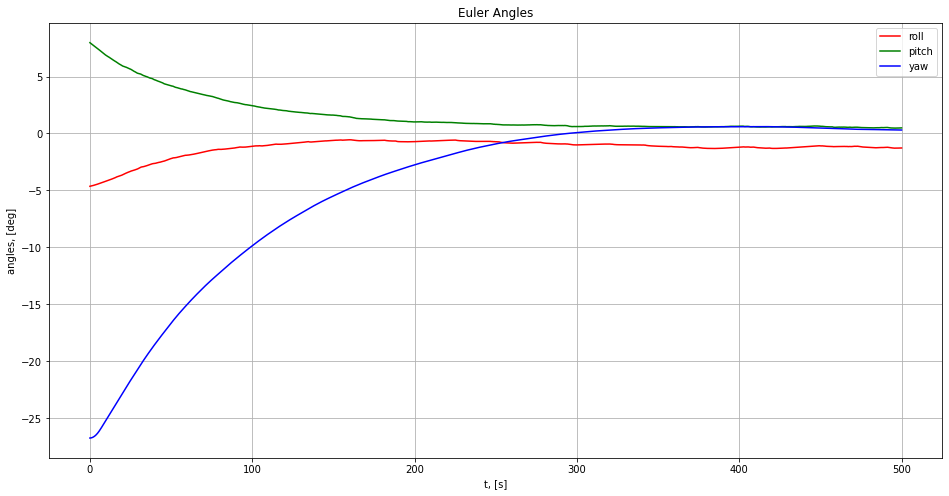

In [97]:
x = np.array(info['x'])
t = np.array(info['t'])
roll, pitch, yaw = quat2rpy_deg(x[:,0], x[:,1], x[:,2], x[:,3])
size = roll.shape[0]//3
print(f'means:\nroll={np.mean(roll[-size:])}\tpitch={np.mean(pitch[-size:])}\tyaw={np.mean(yaw[-size:])}\n\
std:\nroll={np.std(roll[-size:])}\tpitch={np.std(pitch[-size:])}\tyaw={np.std(yaw[-size:])}')

plot_euler_angles(t, roll, pitch, yaw, filename='angles2.pdf', inset=False)

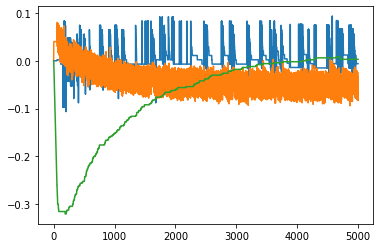

In [98]:
plt.plot(x[:, 7:10])

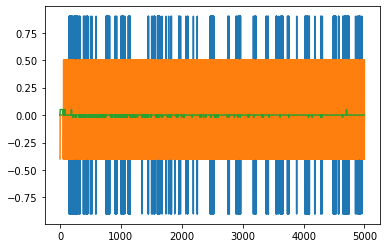

In [99]:
plt.plot(np.array(info['action'])[:])

In [ ]:
start = np.array([np.cos(np.pi/2),0,0,np.sin(np.pi/2),0,0,0,0,0,0])

In [ ]:
roll, pitch, yaw = quat2rpy_deg(x[:,0], x[:,1], x[:,2], x[:,3])
   
fig1 = plt.figure(figsize=(16,8))
ax1 = fig1.add_subplot(2,2,1)

ax1.set_title("Euler Angles")
ax1.plot(t, roll, label = 'roll', color = 'red')
ax1.plot(t, pitch, label = 'pitch', color = 'green')
ax1.plot(t, yaw, label = 'yaw', color = 'blue')
ax1.set_ylabel(r'angles, [deg]')
ax1.set_xlabel(r't, [s]')
ax1.grid(True)
ax1.legend()

ax2 = fig1.add_subplot(2,2,2)

ax2.set_title("Angular Velocity")
ax2.plot(t, x[:,4], label = '$\omega_x$', color = 'red')
ax2.plot(t, x[:,5], label = '$\omega_y$', color = 'green')
ax2.plot(t, x[:,6], label = '$\omega_z$', color = 'blue')
ax2.set_ylabel(r'angular velocity, [rad/s]')
ax2.set_xlabel(r't, [s]')
ax2.grid(True)
ax2.legend()

ax2 = fig1.add_subplot(2,2,3)

ax2.set_title("RW angular momentum")
ax2.plot(t, x[:,7], label = '$h_x$', color = 'red')
ax2.plot(t, x[:,8], label = '$h_y$', color = 'green')
ax2.plot(t, x[:,9], label = '$h_z$', color = 'blue')
ax2.set_ylabel(r'h, [Nms]')
ax2.set_xlabel(r't, [s]')
ax2.grid(True)
ax2.legend()

plt.tight_layout()

## Saving the weights

In [83]:
actor_config = actor.get_config()
actor_weights = actor.get_weights()
critic_config = critic.get_config()
critic_weights = critic.get_weights()
import pickle
name = f'configs_weights.pickle'
with open(name, 'wb') as f:
  pickle.dump((actor_config, actor_weights, critic_config, critic_weights), f)

## Importing the weights

In [7]:
import pickle
# iterations = 1500
# reward_thresh = 0.0043
name = f'data/configs_weights.pickle'
with open(name, 'rb') as f:
  something = pickle.load(f)

actor_config, actor_weights ,critic_config, critic_weights = something
actor = keras.Model.from_config(actor_config)
actor.set_weights(actor_weights)
critic = keras.Model.from_config(critic_config)
critic.set_weights(critic_weights)